# Model Training for Ultrasound Image Reconstruction
This notebook sets up the baseline training pipeline for U-Net using ultrasound data.  

In [181]:
import os       # file access
import matplotlib.pyplot as plt     # plotting of the results (possibly later)

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm   # for epoch iteration
from glob import glob   # for dataset preprocessing
from sklearn.model_selection import train_test_split # to perform validation on simulation data
import scipy.io as sio
import numpy as np

############################################################################################################################
# user defined models
from models.resnet import CustomResNet      # custom resnet architecture - CNN baseline
from models.unet   import CustomUNet        # custom unet architecture - better CNN baseline
from models.effunet import EfficientUNetBeamformer  # efficientnet encoder + unet decoder - final model

# user defined scripts
from dataloader.load_rf import load_rf_stack
from dataloader.load_gt import load_gt_stack
from dataloader.dataset import UltrasoundDataset                # custom class to handle ultrasound RF and image data

from utils.visualize_raw import visualize_gt_db
from utils.visualize_raw import visualize_rf_line
from utils.visualize_aug import visualize_gt_db_aug
from utils.visualize_aug import visualize_rf_line_aug

from utils.losses import ssim_loss, mae_loss, combined_loss     # loss functions possibly interesting for US data
from utils.metrics import compute_metrics                       # function to compute SSIM and PSNR for comparisons later


ImportError: cannot import name 'load_gt_stack' from 'dataloader.load_gt' (c:\Users\jdszk\OneDrive - ETH Zurich\Desktop\SoCDAML_Project\ReconstructUS\code\dataloader\load_gt.py)

## Configuration
Define all the training parameters in one variable.

In [ ]:
CONFIG = {
    'model_name': 'resnet',           # options: 'resnet', 'unet', 'effunet'
    'loss_function': 'ssim',          # options: 'ssim', 'mae', 'combined'
    'batch_size': 8,
    'lr': 1e-3,
    'epochs': 150,
    'input_size': None,               # we set it based on the max depth of processed .mat files
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    'data_dir_rf': os.path.join('..', 'data', 'raw'),
    'data_dir_img': os.path.join('..', 'data', 'processed'),
}

In [ ]:
def get_max_rf_depth(rf_paths):
    depths = []
    for rf_file in rf_paths:
        rf_raw = sio.loadmat(rf_file)['rf_raw']
        depths.append(rf_raw.shape[0])
    return max(depths)

rf_paths = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
CONFIG['input_size'] = (1, get_max_rf_depth(rf_paths), 128)
print(CONFIG['input_size']) # should be [1, 3328, 128]


(1, 3328, 128)


## Data Loading
We assume .mat for input RF data and .mat for the reconstructed image files.

In [ ]:
# test rf loading
rf_paths  = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
rf_tensor = load_rf_stack(rf_paths, target_depth=3328)  # Output: [450, 3328, 128]

print("RF tensor shape:", rf_tensor.shape)   # should be [450, 3328, 128]

100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

450


In [ ]:
img_paths = sorted(glob(os.path.join(CONFIG['data_dir_img'], 'img_*.mat')))
gt_tensor = load_gt_stack(img_paths)  # [450, 378, 609]

print("GT tensor shape:", gt_tensor.shape)   # should be [450, 378, 609]

100%|██████████| 6/6 [00:00<00:00, 83.25it/s]


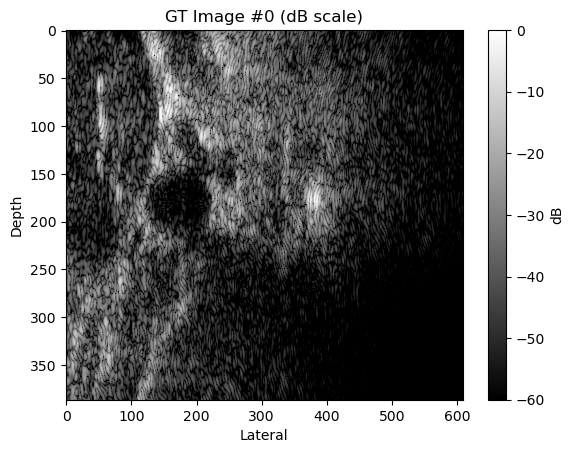

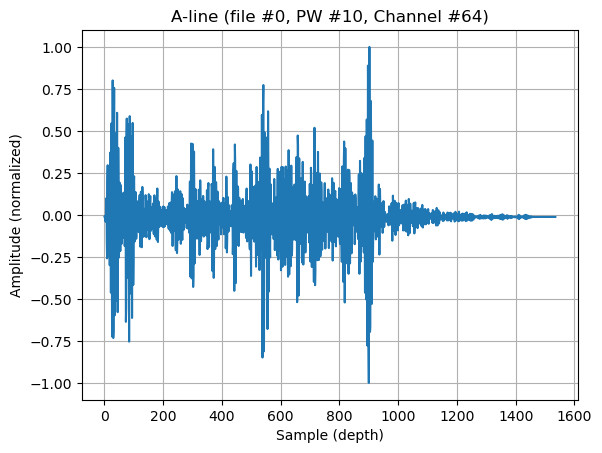

In [99]:
visualize_gt_db(gt_tensor, idx=0)
visualize_rf_line(rf_paths, file_idx=0, pw_idx=10, ch_idx=64)


In [100]:
from sklearn.model_selection import train_test_split

# Indices for splitting
indices = np.arange(rf_tensor.shape[0])
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Split tensors
rf_train, gt_train = rf_tensor[train_idx], gt_tensor[train_idx]
rf_val,   gt_val   = rf_tensor[val_idx],   gt_tensor[val_idx]
rf_test,  gt_test  = rf_tensor[test_idx],  gt_tensor[test_idx]


In [177]:
from torch.utils.data import Dataset, ConcatDataset
# Clean training set
train_clean = UltrasoundDataset(rf_train, gt_train, augment=True, channel_dropout=False)

# Noisy training set (10% of channels randomly zeroed)
train_noisy = UltrasoundDataset(rf_train, gt_train, augment=True, channel_dropout=False)

# Combined training set
train_combined = ConcatDataset([train_clean, train_noisy])

# Validation and test sets
val_ds = UltrasoundDataset(rf_val, gt_val, augment=False, channel_dropout=False)
test_ds = UltrasoundDataset(rf_test, gt_test, augment=False, channel_dropout=False)


In [ ]:
visualize_gt_db_from_sample(gt_clean, title="Clean GT (augmented)")
visualize_gt_db_from_sample(gt_noisy, title="Noisy GT (augmented)")

visualize_rf_from_tensor(rf_clean, title="RF (Clean)")
visualize_rf_from_tensor(rf_noisy, title="RF (With Dropout)")

In [170]:
diff = torch.abs(gt_clean - gt_noisy).mean()
print("Mean absolute diff:", diff.item())  # should be ~1e-6


Mean absolute diff: 0.008891894482076168


In [87]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_combined, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)


In [88]:
# Check a single batch from each loader
train_batch = next(iter(train_loader))
val_batch   = next(iter(val_loader))
test_batch  = next(iter(test_loader))

for name, batch in zip(["Train", "Val", "Test"], [train_batch, val_batch, test_batch]):
    rf, gt = batch
    print(f"{name} RF shape: {rf.shape}, GT shape: {gt.shape}")


Train RF shape: torch.Size([8, 3328, 128]), GT shape: torch.Size([8, 1, 387, 609])
Val RF shape: torch.Size([8, 3328, 128]), GT shape: torch.Size([8, 1, 387, 609])
Test RF shape: torch.Size([8, 3328, 128]), GT shape: torch.Size([8, 1, 387, 609])


## Model Architecture
Here we define the model architecture used for training.

In [ ]:
# the idea is that we use all plane waves as input (for example 75) and then predict 1 image based on that
# TODO: change input channels when the dataset is known
if CONFIG['model_name'] == 'resnet':
    model = CustomResNet()
elif CONFIG['model_name'] == 'unet':
    model = CustomUNet()
elif CONFIG['model_name'] == 'effunet':
    model = EfficientUNetBeamformer()

In [ ]:
# we define standard optimizer and scheduler, loss is defined later based on user CONFIG
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
        optimizer.zero_grad()
        y_pred = model(x)

        if CONFIG['loss_function'] == 'ssim':
            loss = ssim_loss(y_pred, y)
        elif CONFIG['loss_function'] == 'mae':
            loss = mae_loss(y_pred, y)
        elif CONFIG['loss_function'] == 'combined':
            loss = combined_loss(y_pred, y)
            
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [ ]:
def validate(model, loader):
    model.eval()
    val_loss = 0
    total_psnr, total_ssim = 0.0, 0.0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            y_pred = model(x)
            loss = combined_loss(y_pred, y)
            val_loss += loss.item()

            # Detach and move to CPU
            preds = y_pred.detach().cpu().numpy()
            targets = y.detach().cpu().numpy()

            # Compute metrics per sample
            for i in range(preds.shape[0]):
                pred_i = preds[i, 0]  # remove channel dim: [1, H, W] → [H, W]
                target_i = targets[i, 0]

                psnr, ssim = compute_metrics(target_i, pred_i)
                total_psnr += psnr
                total_ssim += ssim

    n = len(loader.dataset)
    return (
        val_loss / len(loader),
        total_psnr / n,
        total_ssim / n
    )


## Model Training
In this part we set up the training loop, train the model and then save the parameters of the final one.

In [ ]:
# Make sure checkpoint directory exists
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

for epoch in tqdm(range(CONFIG['epochs'])):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_psnr, val_ssim = validate(model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0 or (epoch + 1) == CONFIG['epochs']:
        ckpt_path = os.path.join(CONFIG['checkpoint_dir'], f"{CONFIG['model_name']}_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'psnr': val_psnr,
            'ssim': val_ssim,
        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

In [ ]:
final_model_path = os.path.join(CONFIG['checkpoint_dir'], 'final_model.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': CONFIG['epochs'],
}, final_model_path)


## Model Visualization
We visualize one example of the reconstructed images.

In [ ]:
def show_example(model, loader):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(CONFIG['device'])
    with torch.no_grad():
        y_pred = model(x).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x[0, 0].cpu(), cmap='gray')
    axs[0].set_title("Input")
    axs[1].imshow(y[0, 0], cmap='gray')
    axs[1].set_title("Target")
    axs[2].imshow(y_pred[0, 0], cmap='gray')
    axs[2].set_title("Prediction")
    plt.show()
